In [2]:
from delfi.simulator.BaseSimulator import BaseSimulator
import os

import delfi.distribution as dd
import delfi.generator as dg
import numpy as np
import delfi.inference as infer
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
import copy
from mat4py import loadmat
import logging
import datetime
from scipy.io import savemat
import matplotlib.pyplot as plt
from delfi.utils.viz import samples_nd

In [72]:
def subjectSimulator(x, x_center, params, seed=None):
    
    sensitivity = params[0];
    bias = params[1];
    p = (1/(1 + np.exp(-(bias+sensitivity*(x-x_center)) )))
    
    choices = (np.random.uniform(size=[N, np.size(p)]) < p).T * 1
    return np.sum(choices, 1)
    
    
class psychometricModel(BaseSimulator):
    
    def __init__(self, x, seed = None):

        dim_param = 3
        super().__init__(dim_param=dim_param, seed=seed)
        self.x = x
        self.x_min = x[0]
        self.x_max = x[-1]
        self.x_center = (x[0] + x[-1])/2
        self.simulate = subjectSimulator
        
    def gen_single(self, params):
        params = np.asarray(params)
        assert params.ndim == 1, 'params.ndim must be 1'
        hh_seed = self.gen_newseed()
        y = self.simulate(self.x, self.x_center, params, seed=hh_seed)
        return {'y': y.reshape(-1)}

In [79]:
class psychometricStats(BaseSummaryStats):
    
    def __init__(self):
        super().__init__()
    def calc(self,repetition_list):
        seg = 100
        stats = []
        for r in range(len(repetition_list)):
            data = repetition_list[r]
            stats.extend(data['y'])
        return [stats]

In [86]:
# ground truth of parameters

min_x = -10
max_x = 10
N = 10 # 10 trials at each orientation
x = np.linspace(min_x, max_x, 21) # the experiment is conducted at 21 x's
x_center = (min_x + max_x)/ 2
# t = np.linspace(-10, 10, 101)
bias = .8
sensitivity = 1.2

true_params = [sensitivity, bias]
labels_params = ['sensitivity', 'bias']
    
p = (1/(1 + np.exp(-(bias+true_params[0]*(x-x_center)) )))

choices = (np.random.uniform(size=[N, np.size(p)]) < p).T * 1
np.sum(choices, 1)

# define linear noise model
m = psychometricModel(x)

# generate and show observation
obs0 = m.gen_single(true_params)

In [87]:
# define prior
prior_min = np.array([0.2, -5])
prior_max = np.array([1.5, 5])
seed_p = 2
prior =  dd.Uniform(lower = prior_min , upper = prior_max,seed = seed_p)

s = psychometricStats()
g = dg.Default(model=m, prior=prior, summary=s)

# define statsitics summary of observation 
obs_stats = s.calc([obs0])

In [ ]:
n_train = 5000
n_rounds = 2
seed_inf = 1
pilot_samples = 2000

val_frac = 0.05
# network setup
n_hiddens = [50,50]
minibatch = 500
epochs = 100

prior_norm = True

# MAF parameters
density = 'mog'
# n_mades = 5         # number of MADES

# inference object
res = infer.APT(g,
                obs=obs_stats,
                n_hiddens=n_hiddens,
                seed=seed_inf,
                pilot_samples=pilot_samples,
                prior_norm=prior_norm,
                density=density)#,
#                n_mades = n_mades)

# train
log, _, posterior = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                epochs=epochs,
                silent_fail=False,
                proposal='gaussian',
                val_frac=val_frac,
                verbose=True,)

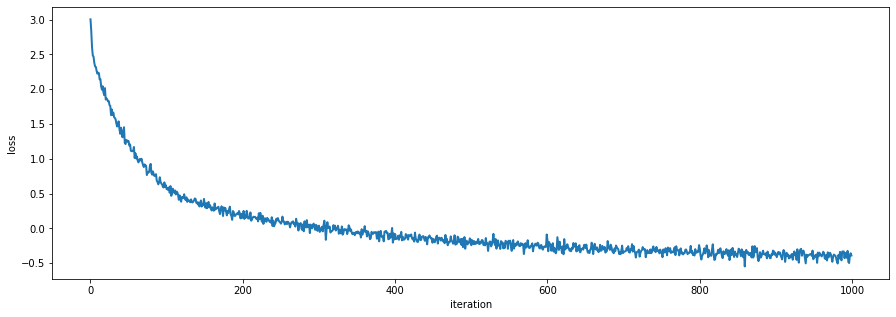

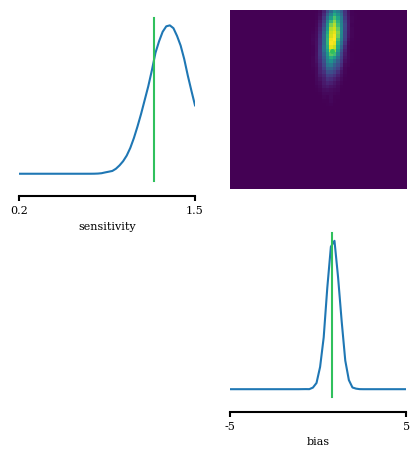

In [90]:
fig = plt.figure(figsize=(15,5))

plt.plot(log[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss');

prior_min = g.prior.lower
prior_max = g.prior.upper
prior_lims = np.concatenate((prior_min.reshape(-1,1),prior_max.reshape(-1,1)),axis=1)

posterior_samples = posterior[0].gen(10000)

###################
# colors
hex2rgb = lambda h: tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# RGB colors in [0, 255]
col = {}
col['GT']      = hex2rgb('30C05D')
col['SNPE']    = hex2rgb('2E7FE8')
col['SAMPLE1'] = hex2rgb('8D62BC')
col['SAMPLE2'] = hex2rgb('AF99EF')

# convert to RGB colors in [0, 1]
for k, v in col.items():
    col[k] = tuple([i/255 for i in v])

###################
# posterior
fig, axes = samples_nd(posterior_samples,
                       limits=prior_lims,
                       ticks=prior_lims,
                       labels=labels_params,
                       fig_size=(5,5),
                       diag='kde',
                       upper='kde',
                       hist_diag={'bins': 50},
                       hist_offdiag={'bins': 50},
                       kde_diag={'bins': 50, 'color': col['SNPE']},
                       kde_offdiag={'bins': 50},
                       points=[true_params],
                       points_offdiag={'markersize': 5},
                       points_colors=[col['GT']],
                       title='');